In [1]:
import pandas as pd
import os
import numpy as np
import pickle

In [2]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/fit')

In [3]:
# which data to use
prefix = 'transect'
inDIR = '../data/training/'
inFILE = 'vor_2014_2023_cln_2024_04_04_' + prefix + '_hls_idxs.csv'
inPATH = os.path.join(inDIR, inFILE)

# date column name
date_col = 'Date_mean'
# dependent variable column
y_col = 'Biomass_kg_ha'
# unique ID column name
id_col = 'Id'

var_names = [
    'NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7', 'SAVI',
    'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI', 'TCGI', 'TCWI',
    'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246', 'BAI_346',
    'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2'
]

In [4]:
df = pd.read_csv(inPATH, parse_dates=[date_col])
df = df[~df[var_names + [y_col]].isnull().any(axis=1)].copy()
df['Plot'] = df[id_col].transform(lambda x: '_'.join(x.split('_')[:-1]))

In [5]:
with open('./results/tmp/ml_train_cper_bm_transect_cv_Year_tuneby_Year_results.pk', 'rb') as f:
    mod_dict = pd.compat.pickle_compat.load(f)

In [6]:
k = 'PLS'

In [7]:
param_best = {}
param_best_dict = {p: [] for p in mod_dict[k]['param_grid'].keys()}
for y in mod_dict[k]['tune_results'].keys():
    param_best_dict_tmp = mod_dict[k]['tune_results'][y]['params'][mod_dict[k]['tune_results'][y]['mean_test_' + mod_dict[k]['tune_refit']].argmax()]
    for p in param_best_dict_tmp.keys():
        param_best_dict[p].append(param_best_dict_tmp[p])
#print(param_best_dict)
for p in param_best_dict:
    if all([type(i) in [float, np.float64] for i in param_best_dict[p]]):
        param_best[p] = np.mean(param_best_dict[p])
    elif all([type(i) in [int, np.int64] for i in param_best_dict[p]]):
        param_best[p] = int(np.mean(param_best_dict[p]))
    elif all([i is None for i in param_best_dict[p]]):
        param_best[p] = None
    else:
        print('ERROR')

In [8]:
mod_fnl = mod_dict[k]['base_mod'].set_params(**param_best)

In [9]:
from sklearn import compose

In [10]:
import inspect
import ast
import re

def create_function_from_string(func_string):
    """Creates a Python function from a string."""

    # Parse the string into an abstract syntax tree (AST)
    tree = ast.parse(func_string)

    # Compile the AST into a code object
    code = compile(tree, '<string>', 'exec')

    # Execute the code object to create the function in the current namespace
    exec(code)

    # Extract the function name from the AST
    func_name = tree.body[0].name

    # Return the created function
    return locals()[func_name]


In [11]:
sqrty = create_function_from_string(inspect.getsource(mod_dict[k]['xfrm_y']))
#xfrm_y_func.__name__ = 'xfrm_y'
sqrty_bt = create_function_from_string(inspect.getsource(mod_dict[k]['bxfrm_y']))
#bxfrm_y_func.__name__ = 'bxfrm_y'

In [12]:
xfrm_y = exec('lambda x:' + re.sub('\n', '',
                                   re.sub('(?s)^.*?(return )', '',
                                          inspect.getsource(mod_dict[k]['xfrm_y']))))
bxfrm_y = exec('lambda x:' + re.sub('\n', '',
                                   re.sub('(?s)^.*?(return )', '',
                                          inspect.getsource(mod_dict[k]['bxfrm_y']))))

In [64]:
regr = compose.TransformedTargetRegressor(regressor=mod_fnl,
                                          func=xfrm_y,
                                          inverse_func=bxfrm_y)

In [65]:
regr = regr.fit(df[var_names], df[y_col])

In [68]:
df['predy'] = regr.predict(df[var_names])

In [173]:
plot_group_cols = ['Pasture', date_col, 'Year', 'Season', 'Plot']

In [106]:
df_plot0 = df[plot_group_cols + ['Biomass_kg_ha', 'predy']].groupby(plot_group_cols).mean().reset_index()

In [107]:
resids_to_save = (df_plot0[y_col] - df_plot0['predy']).values

In [179]:
with open('../models/biomass/cper_bm_pls_boot/CPER_HLS_to_VOR_biomass_model_pls_20241015_plot_resids.npy', 'wb') as f:
    np.save(f, resids_to_save)

In [99]:
from tqdm.notebook import tqdm
import glob
import random
import matplotlib.pyplot as plt

In [100]:
nboot = 100
preds = []

In [ ]:
for b in tqdm(range(nboot)):
    # see https://doi.org/10.1016/j.jbusres.2016.03.049
    df_sub = df.sample(frac=0.9)
    regr.fit(df_sub[var_names], df_sub[y_col])
    with open('../models/biomass/cper_bm_pls_boot/CPER_HLS_to_VOR_biomass_model_pls_20241015_boot' + str(b) + '.pk', 'wb') as f:
        pickle.dump(regr, f)

In [109]:
mod_list = glob.glob('../models/biomass/cper_bm_pls_boot/*.pk')

In [110]:
rand_mod_idx = random.sample(range(len(mod_list)), nboot)
preds = []
for b in tqdm(rand_mod_idx):
    with open(mod_list[b], 'rb') as f:
        mod_tmp = pd.compat.pickle_compat.load(f)
    preds_tmp = mod_tmp.predict(df[var_names])
    rand_indices_tmp = np.random.randint(0, len(resids_to_save), len(df))
    resids_tmp = pd.Series(resids_to_save).iloc[rand_indices_tmp].values
    preds.append(pd.Series(preds_tmp + resids_tmp, name='predy_' + str(b)))

  0%|          | 0/100 [00:00<?, ?it/s]

In [111]:
df = pd.concat([df.reset_index(drop=True)]+preds, axis=1)

In [112]:
plot_keep_cols = [c for c in df.columns if ('predy' in c) or (c in plot_group_cols + ['Biomass_kg_ha'])]

In [113]:
df_plot1 = df[plot_keep_cols].groupby(plot_group_cols).mean().reset_index()

In [118]:
pred_means = df_plot1[[c for c in df_plot1.columns if 'predy_' in c]].mean(axis=1)
err_lwr = pred_means - df_sub[[c for c in df_plot1.columns if 'predy_' in c]].apply(lambda x: np.percentile(x, 2.5), axis=1)
err_upr = df_plot1[[c for c in df_plot1.columns if 'predy_' in c]].apply(lambda x: np.percentile(x, 97.5), axis=1) - pred_means
std_means = df_plot1[[c for c in df_plot1.columns if 'predy_' in c]].std(axis=1)

In [144]:
np.mean(np.abs(resids_to_save))

196.58657344389007

In [153]:
df_plot1['std_means'].mean()

145.20599171916177

In [135]:
import statsmodels.api as sm
import seaborn as sns

In [150]:
#define response variable
y = std_means

#define explanatory variable
x = np.sqrt(np.abs(resids_to_save))

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5505
Date:                Fri, 18 Oct 2024   Prob (F-statistic):              0.458
Time:                        12:03:59   Log-Likelihood:                -10517.
No. Observations:                2413   AIC:                         2.104e+04
Df Residuals:                    2411   BIC:                         2.105e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.6436      0.850    170.145      0.0

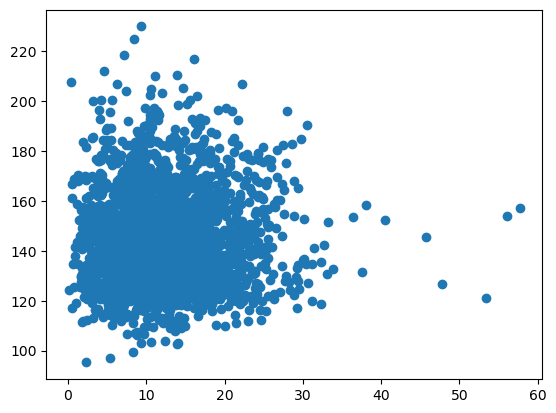

In [151]:
plt.scatter(np.sqrt(np.abs(resids_to_save)), std_means)

In [136]:
df_plot1['std_means'] = std_means

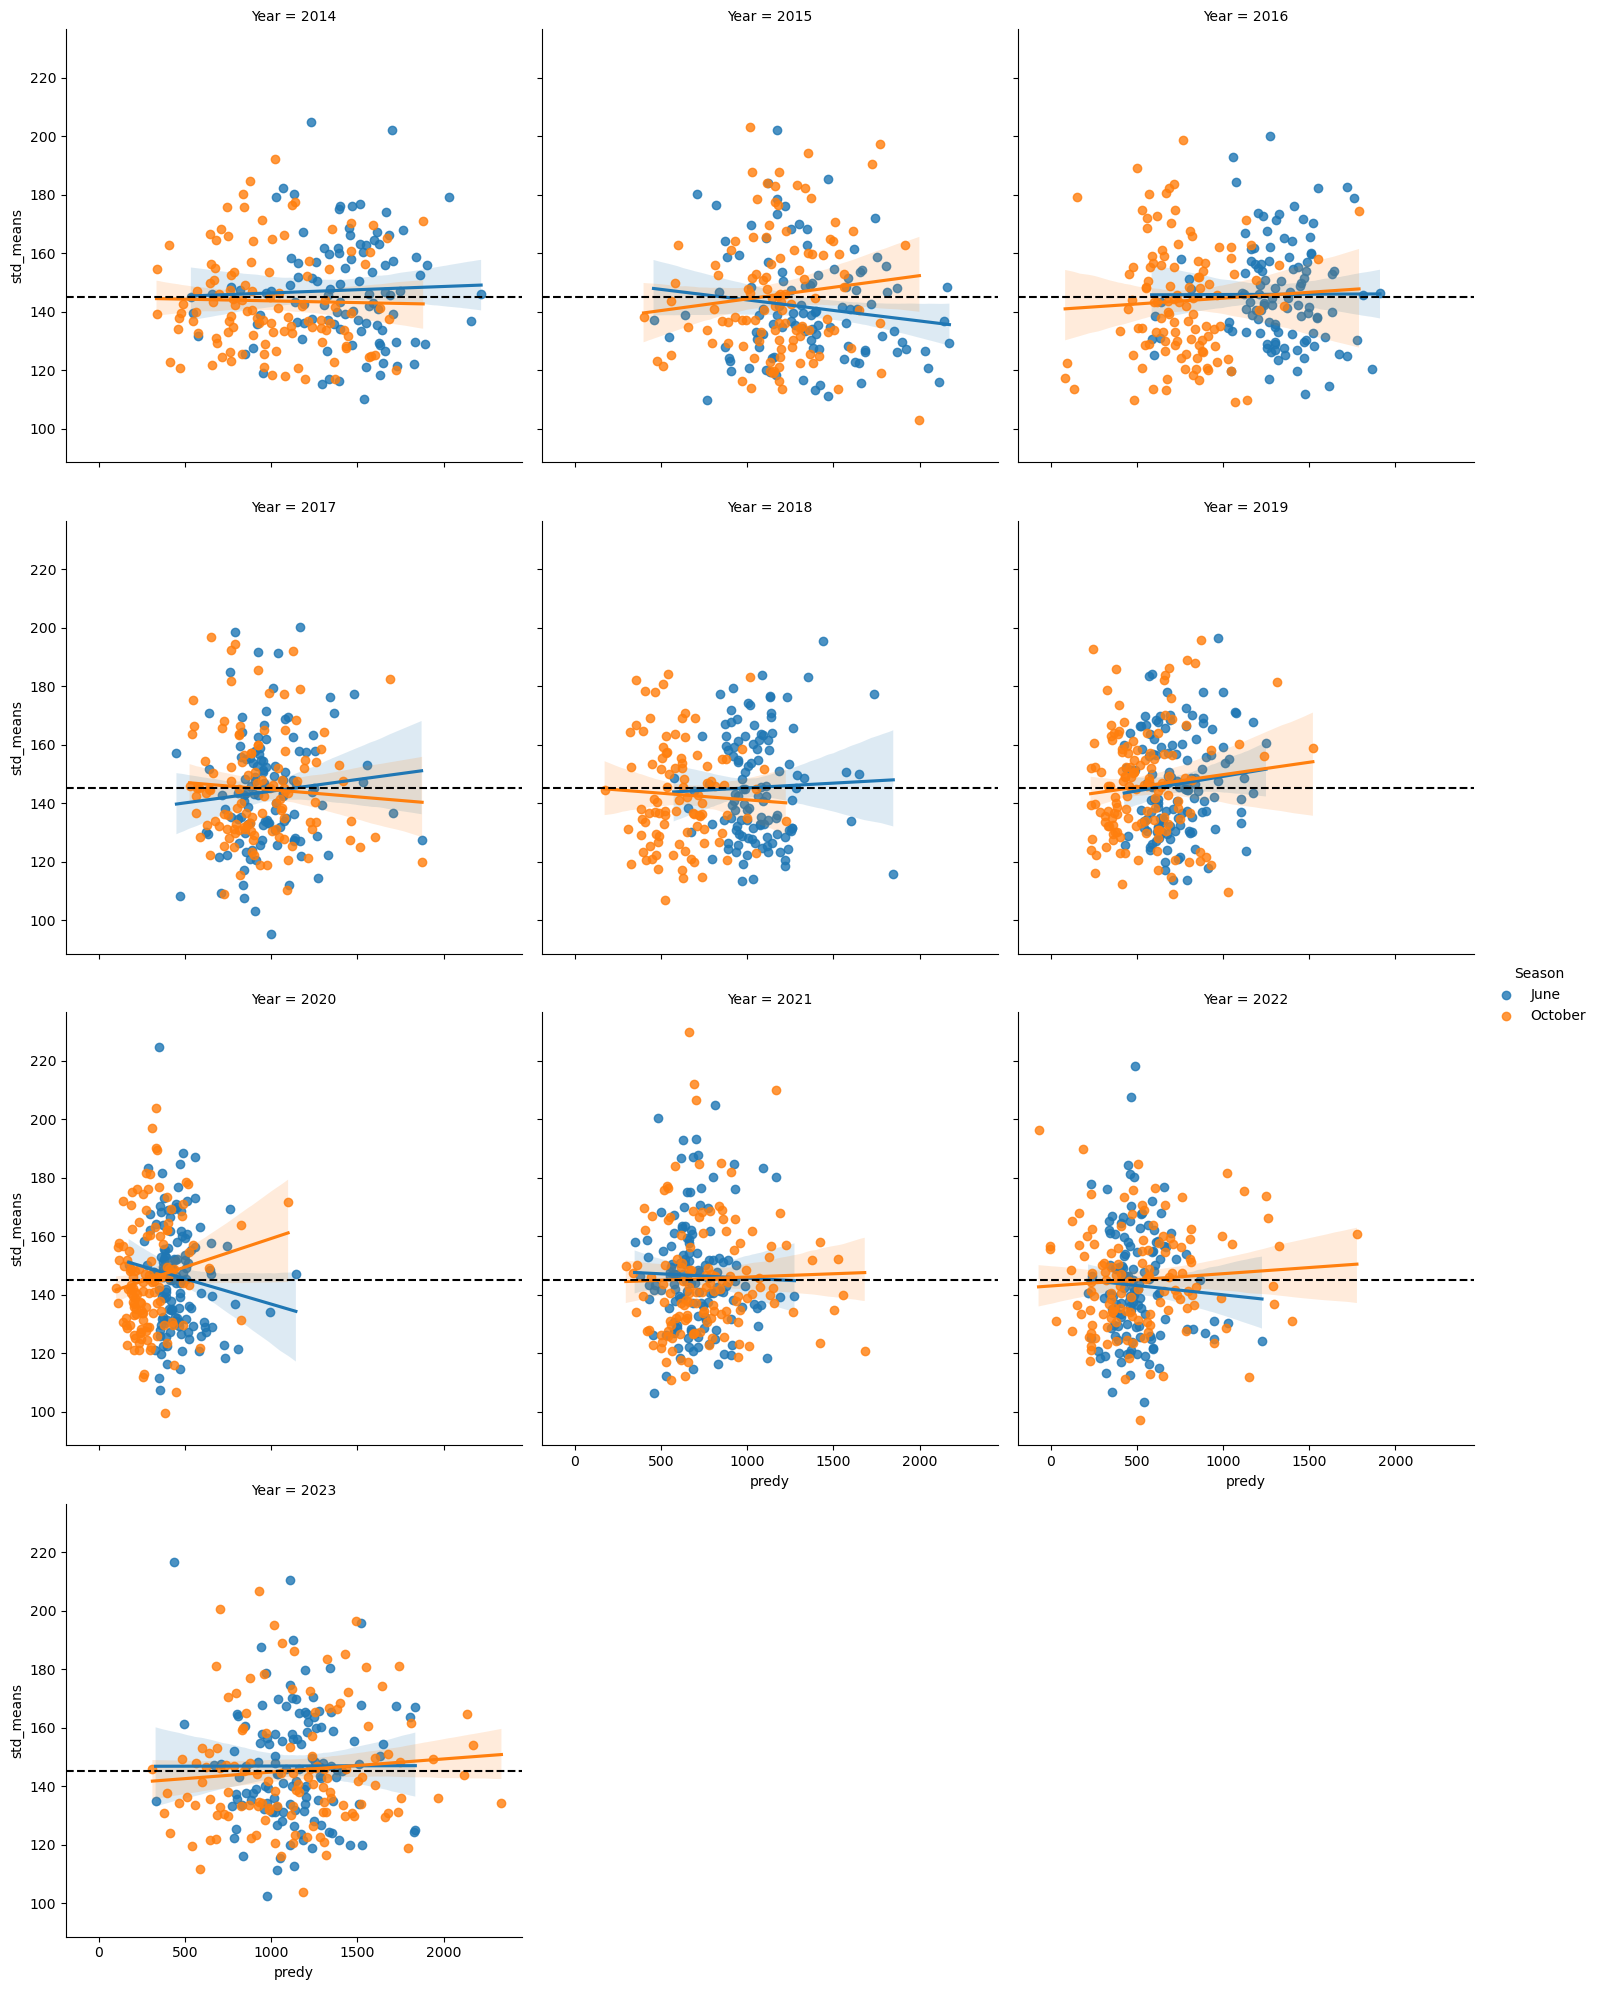

In [142]:
p = sns.lmplot(x='predy', y='std_means', hue='Season', col='Year', col_wrap=3, data=df_plot1)
for ax in p.axes.flatten():
    ax.axhline(y=df_plot1['std_means'].mean(), color='black', linestyle='dashed')

In [134]:
#define response variable
y = std_means[pred_means > 0]

#define explanatory variable
x = np.sqrt(pred_means[pred_means > 0])

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.024
Date:                Fri, 18 Oct 2024   Prob (F-statistic):             0.0450
Time:                        11:53:54   Log-Likelihood:                -10503.
No. Observations:                2411   AIC:                         2.101e+04
Df Residuals:                    2409   BIC:                         2.102e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        142.1049      1.581     89.900      0.0

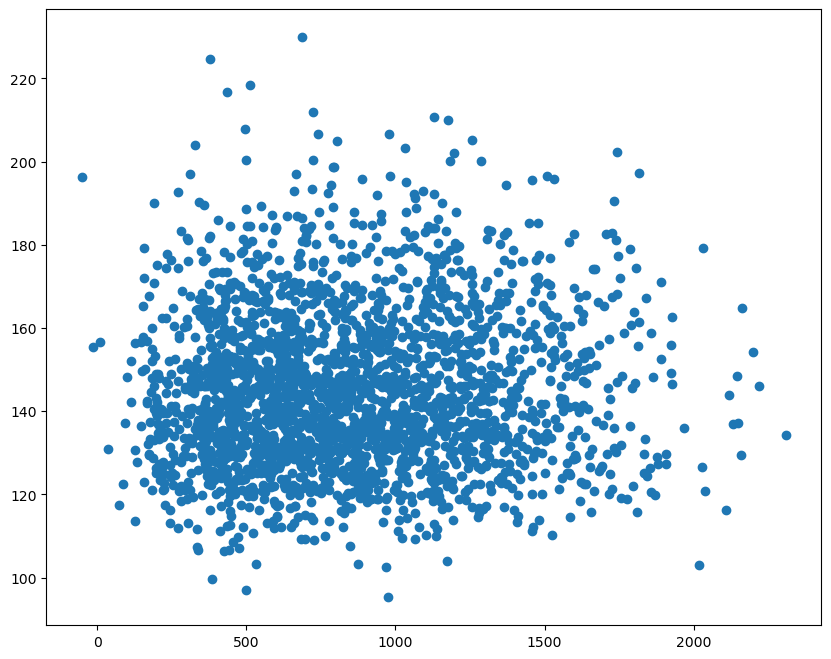

In [120]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(pred_means, std_means)

In [114]:
df_sub = df_plot1[(df_plot1['Pasture'] == '10S') & (df_plot1['Plot'] == '10S_P1')]

In [ ]:
pred_means = df_sub[[c for c in df_plot1.columns if 'predy_' in c]].mean(axis=1)
err_lwr = pred_means - df_sub[[c for c in df_plot1.columns if 'predy_' in c]].apply(lambda x: np.percentile(x, 2.5), axis=1)
err_upr = df_sub[[c for c in df_plot1.columns if 'predy_' in c]].apply(lambda x: np.percentile(x, 97.5), axis=1) - pred_means
std_means = df_sub[[c for c in df_plot1.columns if 'predy_' in c]].std(axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
#ax.scatter(df_sub[date_col], 
#           df_sub[[c for c in df_plot1.columns if 'predy_' in c]].mean(axis=1))
#ax.scatter(df_sub[date_col], 
#           df_sub['predy'], c='green')
ax.errorbar(df_sub[date_col], 
           pred_means,
           yerr=(err_lwr, err_upr))
ax.errorbar(df_sub[date_col], 
           pred_means,
           yerr=std_means, c='red', ecolor='red')
ax.scatter(df_sub[date_col], 
           df_sub['Biomass_kg_ha'], c='grey')
#ax.plot(np.arange(0, 3000), np.arange(0, 3000), linestyle='dashed', color='black')

In [127]:
with open('/project/cper_neon_aop/hls_nrt_utils/hlsstack/models/CPER_HLS_to_VOR_biomass_model_lr_simp.pk', 'rb') as f:
    bm_mod_old = pd.compat.pickle_compat.load(f)

In [128]:
for v in var_names:
    df = df.rename(columns={v: v.lower()})

In [129]:
df = df.rename(columns={'nir1': 'nir'})

In [130]:
df['predy_old'] = np.exp(bm_mod_old.predict(df[['nir' if x=='NIR1' else x.lower() for x in var_names]]))

In [131]:
import seaborn as sns

In [132]:
df_plot = df[[y_col, 'predy', 'predy_old', 'Year', date_col, 'Plot']].groupby([date_col, 'Plot']).mean()

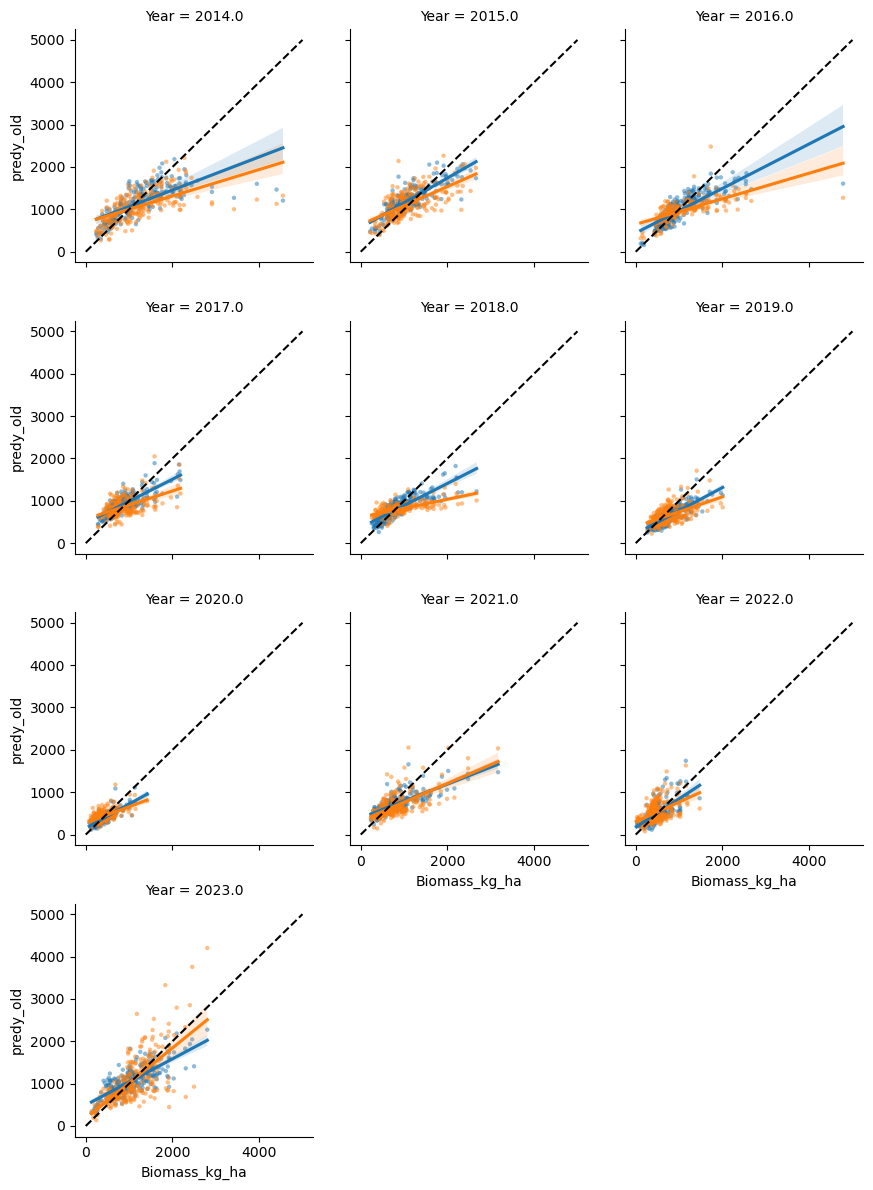

In [53]:
p = sns.FacetGrid(data=df_plot, col='Year', col_wrap=3)
p.map_dataframe(sns.regplot, x=y_col, y='predy', 
                scatter_kws={'s': 10, 'edgecolor': 'none', 'color': 'tab:blue', 'alpha': 0.5},
                line_kws={'color': 'tab:blue'})
p.map_dataframe(sns.regplot, x=y_col, y='predy_old', 
                scatter_kws={'s': 10, 'edgecolor': 'none', 'color': 'tab:orange', 'alpha': 0.5},
                line_kws={'color': 'tab:orange'})
for ax in p.axes.flatten():
    ax.plot(np.arange(0, 5000), np.arange(0, 5000), color='black', linestyle='dashed')

In [133]:
with open('../models/biomass/CPER_HLS_to_VOR_biomass_model_pls_20241015.pk', 'wb') as f:
    pickle.dump(regr, f)